This notebook will take a look at the NM activity 0.5seconds before and after the choice time.

In [31]:

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import utils

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from matplotlib.collections import LineCollection
import pandas as pd

## Load and format the Neuromodulator (NM) data and behavioural labels

In [2]:
# load the dataframe
df_trials_ses = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/df.pkl', "rb"))

In [3]:
# load the dictionary containing the traces
traces = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/traces.pkl', "rb"))

In [4]:
# load the trace times
trace_times = np.load('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/Trace times.npy', allow_pickle=True)

In [5]:
# Combine the traces for all NMs into one 2D array
all_nms = np.array([traces[trace] for trace in traces.keys()])
all_nms = np.transpose(all_nms)

# change it to an array of floats (previously it was an array of object datatype)
all_nms_new = all_nms.astype(np.float64)
all_nms_new.shape

(218572, 4)

In [6]:
n_trials = 1765

In [7]:
# get the choice time 
choice_times = df_trials_ses['choice_time'][0:n_trials].to_numpy()

In [8]:
np.unique(np.isnan(choice_times),return_counts=True)[1][0]

1717

In [16]:
# Make a function to format the NM data into a 1s window around the choice

def format_data(neural_data, window=None ,df = df_trials_ses, trace_times_ = trace_times, choice_times_ = choice_times, window_size=10, n_trials=1765):

    # define the number of trials where the mouse made a choice
    n_choice_trials = np.unique(np.isnan(choice_times_),return_counts=True)[1][0]

    # list to hold all the 1s windows
    n_data_window = []

    # new trial label
    trial_labels = []

    # loop over all trials
    for i in range(0,n_trials):

        # skip trials where the animal didn't make a choice (null choice time)
        if np.isnan(choice_times_[i]):
            continue

        # find the index of the closest time to the choice time in the trace_times array 
        idx = np.abs(trace_times_ - choice_times_[i]).argmin()

        # take the previous 10 and/or the next 10 values of the NM data at these indices - 1s window
        if window =='before':
            n_data_window.append(neural_data[idx-10:idx])

        if window == 'after':
            n_data_window.append(neural_data[idx:idx+10])

        if window == None:
            n_data_window.append(neural_data[idx-10:idx+10])

        # label the timepoints as rewarded or unrewarded
        if df['reward'].iloc[i]:
            # new trial label
            trial_labels.append(1)

        elif df['reward'].iloc[i]==False:
            # new trial label
            trial_labels.append(0)


    # stack the nm data for each trial
    nms_HD = np.stack(n_data_window).reshape((n_choice_trials,-1))
    # format it into a tensor
    nms_HD = torch.from_numpy(nms_HD.astype(np.float64))
    print("neural tensor shape: ", nms_HD.shape)

    # convert trial labels into an array
    trial_labels = np.array(trial_labels)
    print("labels shape: ",trial_labels.shape)

    return nms_HD, trial_labels


In [10]:
all_nms_before, trial_labels_ = format_data(all_nms, window='before')

neural tensor shape:  torch.Size([1717, 40])
labels shape:  (1717,)


In [24]:
trial_labels_

array([1, 0, 0, ..., 1, 0, 0])

## Run analysis and compute embeddings on NM data BEFORE choice

In [12]:
t_embed_b4, b_embed_b4 = utils.build_train_compute(all_nms_before, trial_labels_)

pos:  0.8190 neg:  4.0691 total:  4.8881 temperature:  1.0000: 100%|██████████| 2000/2000 [00:53<00:00, 37.63it/s]
pos:  0.2132 neg:  5.9934 total:  6.2065 temperature:  1.0000: 100%|██████████| 2000/2000 [00:52<00:00, 38.14it/s]


In [13]:
rewarded, unrewarded = utils.define_label_classes(trial_labels=trial_labels_)

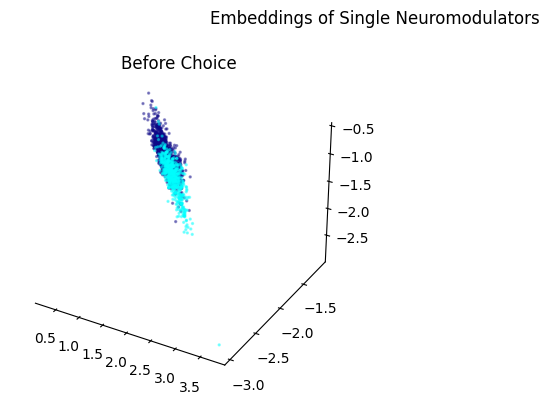

In [15]:
utils.plot4_embeddings([b_embed_b4], labels=trial_labels_,l_class=[rewarded,unrewarded], titles=['Before Choice'])

## Run analysis and compute embeddings on NM data AFTER choice

In [17]:
all_nms_af, trial_labels_af = format_data(all_nms, window='after')

neural tensor shape:  torch.Size([1717, 40])
labels shape:  (1717,)


In [20]:
t_embed_af, b_embed_af = utils.build_train_compute(all_nms_af, trial_labels_af)

pos:  1.0465 neg:  3.1096 total:  4.1561 temperature:  1.0000: 100%|██████████| 2000/2000 [00:50<00:00, 39.48it/s]
pos:  0.3296 neg:  5.4455 total:  5.7751 temperature:  1.0000: 100%|██████████| 2000/2000 [00:52<00:00, 37.90it/s]


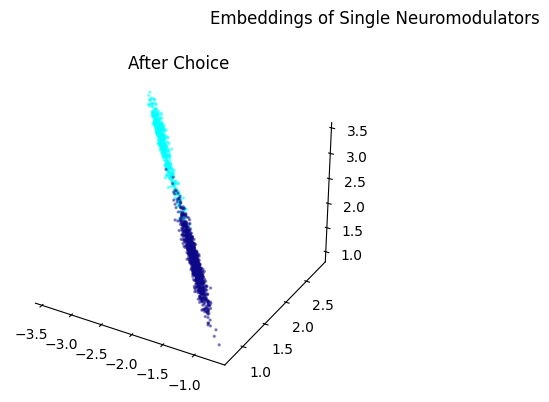

In [23]:
utils.plot4_embeddings([b_embed_af], labels=trial_labels_af, l_class=[rewarded,unrewarded], titles=['After Choice'])

## Quantify how well these embeddings show presence of reward

In [32]:
# define function to get the auc scores
def get_auc(set_of_embeddings,trial_labels, n_iterations=5):   

     # list to store mean auc scores at each of these embedding dimensions
    mean_scores = []
    errors = []

    for j, embedding in enumerate(set_of_embeddings):

        # quantify with AUC score
        scores = []

        # for each NM make a couple of runs of the log regression model to get error bars
        for i in range(n_iterations):

            # make logistic function, fit it and use it to predict the initial labels from the embedding
            logreg = LogisticRegression(random_state=42)
            logreg.fit(embedding, trial_labels)
            prediction = logreg.predict(embedding)

            # quantify how well the embedding mirrors the labels using the auc score

            # make a precision recall curve and get the threshold
            precision, recall, threshold = precision_recall_curve(trial_labels, prediction)
            threshold = np.concatenate([np.array([0]), threshold])

            # calculate the fpr and tpr for all thresholds of the classification
            fpr, tpr, threshold = roc_curve(trial_labels, prediction)

            # get the auc score and append it to the list
            roc_auc = auc(fpr, tpr)
            scores.append(roc_auc)

        # store the mean and the standard deviation 
        mean_scores.append(np.mean(scores))
        errors.append(np.std(scores))

    return mean_scores, errors

In [29]:
trial_labels_

array([1, 0, 0, ..., 1, 0, 0])

In [34]:
x_labels = ['Before choice', 'After Choice']

In [27]:
list_embeddings = [b_embed_b4, b_embed_af]

In [33]:
mean_scores, errors = get_auc(list_embeddings, trial_labels=trial_labels_)

Text(0.5, 1.0, 'AUC score (logistic regression) before and after choice')

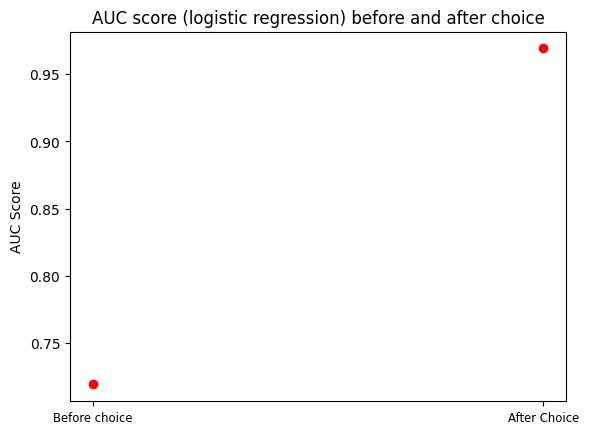

In [35]:
# print the auc score vs the embedding dimension
plt.errorbar(x=np.arange(0,2),y=mean_scores, yerr=errors, fmt='ro')
plt.xlabel("")
plt.xticks(range(len(x_labels)), x_labels, size='small')
plt.ylabel("AUC Score")
plt.title("AUC score (logistic regression) before and after choice")

In [11]:
behaviour_embeddings, time_embedings, t_labels, [rewarded,unrewarded] = utils.nm_analysis_2(all_nms_before,df=df_trials_ses,trace_times=trace_times,choice_times=choice_times,window='before',title="Before Choice")

ValueError: all input arrays must have the same shape